In [1]:
import numpy as np
from math import pi
from qiskit import *
from qiskit.quantum_info.operators import Kraus, SuperOp
from qiskit.providers.aer import QasmSimulator
from qiskit.tools.visualization import plot_histogram

# Qiskit Aer noise module imports
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import QuantumError, ReadoutError
from qiskit.providers.aer.noise.errors import pauli_error, amplitude_damping_error
from qiskit.providers.aer.noise.errors import depolarizing_error, phase_damping_error
from qiskit.providers.aer.noise.errors import thermal_relaxation_error

In [2]:
def getCounts(circuit,q,c,shots):
    job = execute(circuit, backend = Aer.get_backend('qasm_simulator'), shots = shots)
    counts = job.result().get_counts(circuit)
    return plot_histogram(counts)

In [3]:
def prepareState(q,c,pref):
    if pref == 'singlet':
        circ = QuantumCircuit(q,c)
        circ.x(0)
        circ.ry(-pi/2,1)
        circ.cx(q[1],q[0])
        #circ.h(0)
        #circ.cx(q[0],q[1])
        #circ.x(0)
        #circ.z(1)
        #circS.measure(q,c)
        return circ
    elif pref == 'triplet0':
        circ = QuantumCircuit(q,c)
        circ.x(0)
        circ.ry(pi/2,1)
        circ.cx(q[1],q[0])
        #circ.h(0)
        #circ.cx(q[1],q[0])
        #circ.x(0)
        #circ.z(1)
        #circ.measure(q,c)
        return circ
    else:
        circ = QuantumCircuit(q,c)
        circ.x(0)
        #circ.measure(q,c)
        return circ

**Simulating Bit-Flip Error:**

A bit-flip error is a common type of noise that can occur spontaneously. Below we are simulating a bit-flip error at different stages. For example, when applying a single-qubit gate it would flip the state of the qubit with probability p_gate1, and when applying 2-qubit gates, it would apply single-qubit gates error to each qubit. Lastly, when measuring the qubit, it would flip the state before, with probability p_meas. 

NoiseModel:
  Basis gates: ['cx', 'id', 'u1', 'u2', 'u3']
  Instructions with noise: ['u2', 'measure', 'u1', 'cx', 'u3']
  All-qubits errors: ['measure', 'u1', 'u2', 'u3', 'cx']


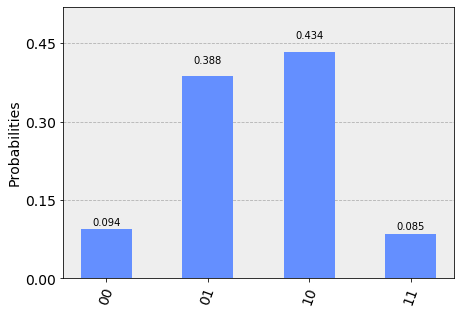

In [4]:
q = QuantumRegister(2)
c = ClassicalRegister(2)
circ = prepareState(q,c,'singlet')
circ.ry(-pi/2,1)
circ.ry(-pi/2,0)
circ.measure(q,c)
# Example error probabilities
##p_reset = 1.0
p_meas = 0.05
p_gate1 = 0.05

# QuantumError objects
##error_reset = pauli_error([('X', p_reset), ('I', 1 - p_reset)])
error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
error_gate1 = pauli_error([('X',p_gate1), ('I', 1 - p_gate1)])
error_gate2 = error_gate1.tensor(error_gate1)

# Add errors to noise model
noise_bit_flip = NoiseModel()
##noise_bit_flip.add_all_qubit_quantum_error(error_reset, "reset")
noise_bit_flip.add_all_qubit_quantum_error(error_meas, "measure")
noise_bit_flip.add_all_qubit_quantum_error(error_gate1, ["u1", "u2", "u3"])
noise_bit_flip.add_all_qubit_quantum_error(error_gate2, ["cx"])

print(noise_bit_flip)

simulator = QasmSimulator()
# Run the noisy simulation
job = execute(circ, simulator,
              basis_gates=noise_bit_flip.basis_gates,
              noise_model=noise_bit_flip)
result_bit_flip = job.result()
counts_bit_flip = result_bit_flip.get_counts(0)

# Plot noisy output
plot_histogram(counts_bit_flip)

**Simulating Phase Flip:**

Using similar parameters to the bit-flip simulation, it seems that the measurement error is not affecting the result. However, an increased gate error affects the result similarly to a bit-flip error. 

NoiseModel:
  Basis gates: ['cx', 'id', 'u1', 'u2', 'u3']
  Instructions with noise: ['u2', 'measure', 'u1', 'cx', 'u3']
  All-qubits errors: ['measure', 'u1', 'u2', 'u3', 'cx']


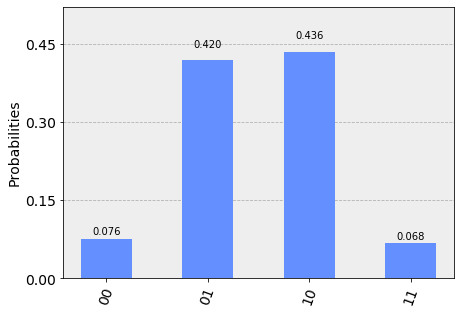

In [5]:
q = QuantumRegister(2)
c = ClassicalRegister(2)
circ = prepareState(q,c,'singlet')
#Measure about x
circ.ry(-pi/2,0) 
circ.ry(-pi/2,1) 
circ.measure(q,c)
# Example error probabilities
##p_reset = 1.0
p_meas = 0.5
p_gate1 = 0.05

# QuantumError objects
##error_reset = pauli_error([('X', p_reset), ('I', 1 - p_reset)])
error_meas = pauli_error([('Z',p_meas), ('I', 1 - p_meas)])
error_gate1 = pauli_error([('Z',p_gate1), ('I', 1 - p_gate1)])
error_gate2 = error_gate1.tensor(error_gate1)

# Add errors to noise model
noise_phase_flip = NoiseModel()
##noise_bit_flip.add_all_qubit_quantum_error(error_reset, "reset")
noise_phase_flip.add_all_qubit_quantum_error(error_meas, "measure")
noise_phase_flip.add_all_qubit_quantum_error(error_gate1, ["u1", "u2", "u3"])
noise_phase_flip.add_all_qubit_quantum_error(error_gate2, ["cx"])

print(noise_phase_flip)

simulator = QasmSimulator()
# Run the noisy simulation
job = execute(circ, simulator,
              basis_gates=noise_phase_flip.basis_gates,
              noise_model=noise_phase_flip)
result = job.result()
counts = result.get_counts(0)

# Plot noisy output
plot_histogram(counts)

**Simulating a Depolarization Error:**

The effect of the depolarizing noise increases linearly where 100% depolarizing error means that when a qubit will be in a completely mixed state. The way this noise can be visualized, is that when you have a single qubit, represented as a Bloch sphere, the sphere will shrink and when at 100%, it will just be a point in the center, when means that all information about your qubit is lost.

NoiseModel:
  Basis gates: ['cx', 'id', 'u1', 'u2', 'u3']
  Instructions with noise: ['u2', 'u1', 'cx', 'u3']
  All-qubits errors: ['u1', 'u2', 'u3', 'cx']


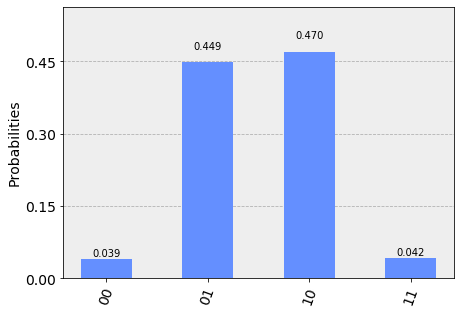

In [6]:
q = QuantumRegister(2)
c = ClassicalRegister(2)
circ = prepareState(q,c,'singlet')
circ.measure(q,c)

# Create an empty noise model
noise_model = NoiseModel()

# Add depolarizing error to all single qubit u1, u2, u3 gates
error = depolarizing_error(0.05, 1)
error2 = error.tensor(error)
noise_model.add_all_qubit_quantum_error(error, ['u1', 'u2', 'u3'])
noise_model.add_all_qubit_quantum_error(error2, ["cx"])
# Print noise model info
print(noise_model)

simulator = QasmSimulator()
# Run the noisy simulation
job = execute(circ, simulator,
              basis_gates=noise_model.basis_gates,
              noise_model=noise_model)
result = job.result()
counts = result.get_counts(0)

# Plot noisy output
plot_histogram(counts)

**Simulating Phase Damping:**

If you increase the phase damping to 100%, it results to being in a mixed state, where you have no information about your qubit.

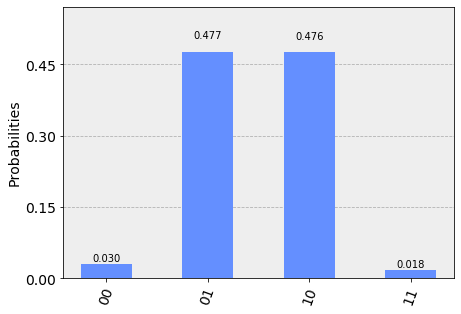

In [7]:
q = QuantumRegister(2)
c = ClassicalRegister(2)
circ = prepareState(q,c,'singlet')
#Measure state along x
circ.ry(-pi/2,1)
circ.ry(-pi/2,0)
circ.measure(q,c)
# Create an empty noise model
noise_model = NoiseModel()

# Add depolarizing error to all single qubit u1, u2, u3 gates
error = phase_damping_error(0.05, 1)
error2 = error.tensor(error)
noise_model.add_all_qubit_quantum_error(error, ['u1', 'u2', 'u3'])
noise_model.add_all_qubit_quantum_error(error2, ["cx"])

simulator = QasmSimulator()
# Run the noisy simulation
job = execute(circ, simulator,
              basis_gates=noise_model.basis_gates,
              noise_model=noise_model)
result = job.result()
counts = result.get_counts(0)

# Plot noisy output
plot_histogram(counts)

**Simulating Amplitude Damping:**

This is a type of energy dissipation, in which energy is lost from the quantum system.

Amplitude damping can be visualized as the Bloch sphere shrinking towards the 0 state. Thus, the idea is that as you increase the amplitude damping error to 100%, the state of your qubit is just the lowest energy state. 

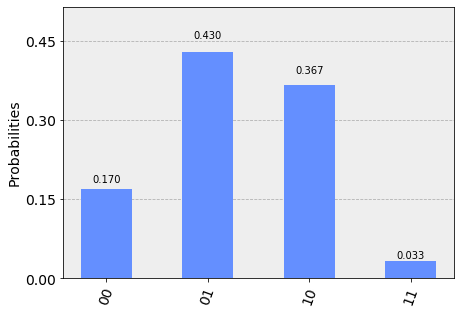

In [8]:
q = QuantumRegister(2)
c = ClassicalRegister(2)
circ = prepareState(q,c,'singlet')
#Measure state along x
#circ.ry(-pi/2,1)
#circ.ry(-pi/2,0)
circ.measure(q,c)

# Create an empty noise model
noise_model = NoiseModel()

# Add depolarizing error to all single qubit u1, u2, u3 gates
error = amplitude_damping_error(0.1, 0, True)
error2 = error.tensor(error)
noise_model.add_all_qubit_quantum_error(error, ['u1', 'u2', 'u3'])
noise_model.add_all_qubit_quantum_error(error2, ["cx"])

simulator = QasmSimulator()
# Run the noisy simulation
job = execute(circ, simulator,
              basis_gates=noise_model.basis_gates,
              noise_model=noise_model)
result = job.result()
counts = result.get_counts(0)

# Plot noisy output
plot_histogram(counts)

**Simulating Thermal Relaxation Error:**

This error is a mixture of generalized amplitude and phase damping.

NoiseModel:
  Basis gates: ['cx', 'id', 'u2', 'u3']
  Instructions with noise: ['u2', 'measure', 'reset', 'cx', 'u3']
  Qubits with noise: [0, 1, 2, 3]
  Specific qubit errors: [('reset', [0]), ('reset', [1]), ('reset', [2]), ('reset', [3]), ('measure', [0]), ('measure', [1]), ('measure', [2]), ('measure', [3]), ('u2', [0]), ('u2', [1]), ('u2', [2]), ('u2', [3]), ('u3', [0]), ('u3', [1]), ('u3', [2]), ('u3', [3]), ('cx', [0, 0]), ('cx', [0, 1]), ('cx', [0, 2]), ('cx', [0, 3]), ('cx', [1, 0]), ('cx', [1, 1]), ('cx', [1, 2]), ('cx', [1, 3]), ('cx', [2, 0]), ('cx', [2, 1]), ('cx', [2, 2]), ('cx', [2, 3]), ('cx', [3, 0]), ('cx', [3, 1]), ('cx', [3, 2]), ('cx', [3, 3])]


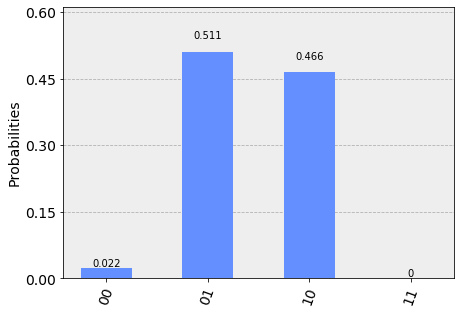

In [9]:
q = QuantumRegister(2)
c = ClassicalRegister(2)
circ = prepareState(q,c,'singlet')
circ.measure(q,c)
# T1 and T2 values for qubits 0-3
T1s = np.random.normal(50e3, 10e3, 4) # Sampled from normal distribution mean 50 microsec
T2s = np.random.normal(70e3, 10e3, 4)  # Sampled from normal distribution mean 50 microsec

# Truncate random T2s <= T1s
T2s = np.array([min(T2s[j], 2 * T1s[j]) for j in range(4)])

# Instruction times (in nanoseconds)
time_u1 = 0   # virtual gate
time_u2 = 50  # (single X90 pulse)
time_u3 = 100 # (two X90 pulses)
time_cx = 300
time_reset = 1000  # 1 microsecond
time_measure = 1000 # 1 microsecond

# QuantumError objects
errors_reset = [thermal_relaxation_error(t1, t2, time_reset)
                for t1, t2 in zip(T1s, T2s)]
errors_measure = [thermal_relaxation_error(t1, t2, time_measure)
                  for t1, t2 in zip(T1s, T2s)]
errors_u1  = [thermal_relaxation_error(t1, t2, time_u1)
              for t1, t2 in zip(T1s, T2s)]
errors_u2  = [thermal_relaxation_error(t1, t2, time_u2)
              for t1, t2 in zip(T1s, T2s)]
errors_u3  = [thermal_relaxation_error(t1, t2, time_u3)
              for t1, t2 in zip(T1s, T2s)]
errors_cx = [[thermal_relaxation_error(t1a, t2a, time_cx).expand(
             thermal_relaxation_error(t1b, t2b, time_cx))
              for t1a, t2a in zip(T1s, T2s)]
               for t1b, t2b in zip(T1s, T2s)]

# Add errors to noise model
noise_thermal = NoiseModel()
for j in range(4):
    noise_thermal.add_quantum_error(errors_reset[j], "reset", [j])
    noise_thermal.add_quantum_error(errors_measure[j], "measure", [j])
    noise_thermal.add_quantum_error(errors_u1[j], "u1", [j])
    noise_thermal.add_quantum_error(errors_u2[j], "u2", [j])
    noise_thermal.add_quantum_error(errors_u3[j], "u3", [j])
    for k in range(4):
        noise_thermal.add_quantum_error(errors_cx[j][k], "cx", [j, k])

print(noise_thermal)

# Run the noisy simulation
job = execute(circ, simulator,
              basis_gates=noise_thermal.basis_gates,
              noise_model=noise_thermal)
result_thermal = job.result()
counts_thermal = result_thermal.get_counts(0)

# Plot noisy output
plot_histogram(counts_thermal)

Hello I am Eva. I am cool. But Eric is cooler because he thinks that he can correct on everything but little he does know that I hate him and he is mean to me every day. 